# Project 2 ChE 2410
### Replication of the study: A general kinetic model for the hydrothermal liquefaction of microalgae

_Peter J. Valdez, Vincent J. Tocco, Phillip E. Savage_ 

2014, Bioresource Journal


$\dot{x}_{1_p} = -(k_{1_p} + k_{2_p}) \cdot x_{1_p} $

$\dot{x}_{1_1} = -(k_{1_1} + k_{2_1}) \cdot x_{1_1} $

$\dot{x}_{1_c} = -(k_{1_c} + k_{2_c}) \cdot x_{1_c} $

$\dot{x}_2 = -(k_4 + k_5) \cdot x_2 + k_{1_p} \cdot x_{1_p} + k_{1_1} \cdot x_{1_1} + k_{1_c} \cdot x_{1_c} + k_3 \cdot x_3 $

$\dot{x}_3 = -(k_3 + k_6) \cdot x_3 + k_{2_p} \cdot x_{1_p} + k_{2_1} \cdot x_{1_1} + k_{2_c} \cdot x_{1_c} + k_4 \cdot x_2 $

$\dot{x}_4 = k_5 \cdot x_2 + k_6 \cdot x_3 $

$x_1 = x_{1_p} + x_{1_1} + x_{1_c}$


In [1]:
#import required modules
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

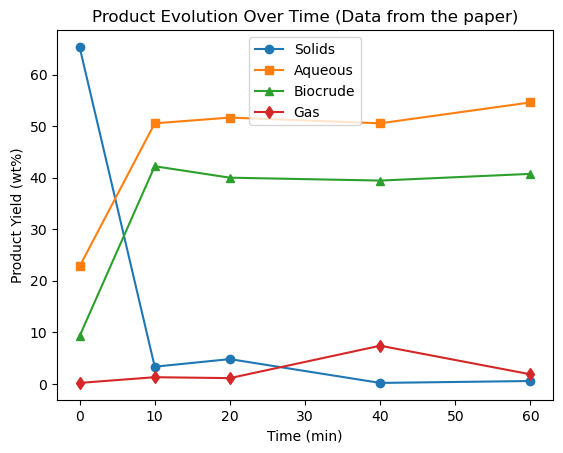

In [2]:
#parameters and data from the paper
time = np.array([0, 10, 20, 40, 60])
solids = np.array([65.37,3.33,4.8,0.18,0.55])
protein = solids * 0.56
carbs = solids * 0.32
lipids = solids * 0.09
aqueous = np.array([22.77,50.55,51.66,50.55,54.6])
biocrude = np.array([9.26,42.22,40,39.44,40.74])
gas = np.array([0.18,1.29,1.11,7.4,1.85])

#plotting the original data
plt.plot(time, solids, label='Solids', marker='o')
plt.plot(time, aqueous, label='Aqueous', marker='s')
plt.plot(time, biocrude, label='Biocrude', marker='^')
plt.plot(time, gas, label='Gas', marker='d')

plt.title('Product Evolution Over Time (Data from the paper)')
plt.xlabel('Time (min)')
plt.ylabel('Product Yield (wt%)')
plt.legend()
plt.show()

In [3]:
training_data = np.vstack((protein, lipids, carbs, aqueous, biocrude, gas)).T
#print(training_data)

In [4]:
def MyODEs(y,t, k1_p, k2_p, k1_1, k2_1, k1_c, k2_c, k4, k5, k3, k6):
    xp, xl, xc, x2, x3, x4 = y
    dxpdt = -(k1_p + k2_p) * xp  # proteins
    dxldt = -(k1_1 + k2_1) * xl  # lipids
    dxcdt = -(k1_c + k2_c) * xc  # carbs
    dx2dt = -(k4 + k5) * x2 + k1_p * xp + k1_1 * xl + k1_c * xc + k3 * x3  # aqueous phase
    dx3dt = -(k3 + k6) * x3 + k2_p * xp + k2_1 * xl + k1_c * xc + k4 * x2  # biocrude
    dx4dt = k5 * x2 + k6 * x3  # gas
    return [dxpdt, dxldt, dxcdt, dx2dt, dx3dt, dx4dt]

In [5]:
t_steps = np.array([0, 10, 20, 40, 60])
y0_2 = np.array([protein[0], lipids[0], carbs[0], aqueous[0], biocrude[0], gas[0]])
def RMSE_MyODEs(params):
    k1_p, k2_p, k1_1, k2_1, k1_c, k2_c, k4, k5, k3, k6 = params
    ODE_output = odeint(MyODEs, y0_2, t_steps, args=(k1_p, k2_p, k1_1, k2_1, k1_c, k2_c, k4, k5, k3, k6))
    err = training_data - ODE_output
    return np.sqrt(np.sum(err**2))

In [6]:
#all k values should be positive
bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), 
          (0, None), (0, None), (0, None), (0, None), (0, None)]
initial_guess = [0.18, 0.11, 0.29, 0.10, 0.28, 0.00008, 0.1, 0.0002, 0.1, 0.00019]
result = minimize(RMSE_MyODEs, initial_guess, bounds=bounds)

print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.249566743001406
        x: [ 1.172e-01  1.880e-01  3.101e-01  1.353e-01  1.588e-01
             1.627e-01  2.453e-02  0.000e+00  3.206e-02  1.652e-03]
      nit: 117
      jac: [-8.280e-03  5.568e-03 -1.824e-03 -2.973e-02 -1.553e-02
             1.233e-02  1.478e-01  2.743e+01 -1.197e-01  2.132e-01]
     nfev: 1749
     njev: 159
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>


In [7]:
optimized_params = result.x
print("Optimized Parameters:")
print("k1_p:", optimized_params[0])
print("k2_p:", optimized_params[1])
print("k1_1:", optimized_params[2])
print("k2_1:", optimized_params[3])
print("k1_c:", optimized_params[4])
print("k2_c:", optimized_params[5])
print("k4:", optimized_params[6])
print("k5:", optimized_params[7])
print("k3:", optimized_params[8])
print("k6:", optimized_params[9])

Optimized Parameters:
k1_p: 0.11720054583394836
k2_p: 0.18798439006590936
k1_1: 0.3100758610406755
k2_1: 0.13526593674279422
k1_c: 0.15881071233055613
k2_c: 0.16271956895528125
k4: 0.024527885103684106
k5: 0.0
k3: 0.03205828150490094
k6: 0.001651624628330452


In [8]:
k1_p_paper= 0.2
k2_p_paper= 0.13
k1_1_paper= 0.35
k2_1_paper= 0.11
k1_c_paper= 0.35
k2_c_paper= 0.0001
k4_paper= 0.12
k5_paper= 0.0004
k3_paper= 0.14
k6_paper= 0.0002

In [9]:
ODE_paper_results = odeint(MyODEs, y0_2, t_steps, args=(k1_p_paper, k2_p_paper, k1_1_paper, k2_1_paper, k1_c_paper, k2_c_paper,k4_paper,k5_paper, k3_paper,k6_paper))
ODE_paper_results_solids = ODE_paper_results[:, 0] + ODE_paper_results[:, 1] + ODE_paper_results[:, 2] #solids are the summation of lipids+carbs+prot
ODE_paper_results_aqueous = ODE_paper_results[:, 3]
ODE_paper_results_biocrude = ODE_paper_results[:, 4]
ODE_paper_results_gas = ODE_paper_results[:, 5]

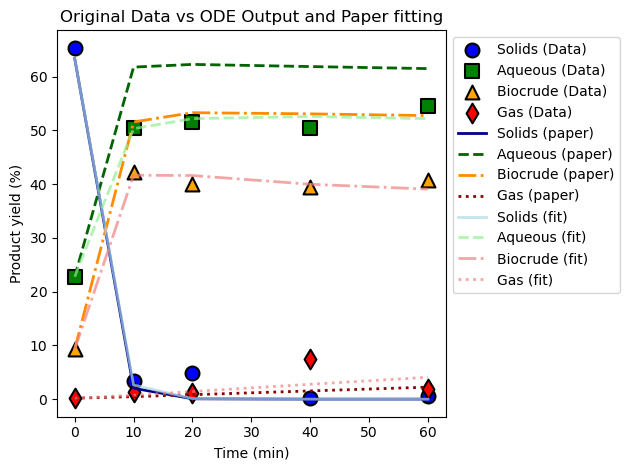

In [10]:
#plotting the fitted vs the original data
ODE_output_results = odeint(MyODEs, y0_2, t_steps, args=(optimized_params[0], optimized_params[1], optimized_params[2], optimized_params[3], optimized_params[4], optimized_params[5],optimized_params[6],optimized_params[7], optimized_params[8],optimized_params[9]))
ODE_output_results_solids = ODE_output_results[:, 0] + ODE_output_results[:, 1] + ODE_output_results[:, 2]
ODE_output_results_aqueous = ODE_output_results[:, 3]
ODE_output_results_biocrude = ODE_output_results[:, 4]
ODE_output_results_gas = ODE_output_results[:, 5]

plt.scatter(t_steps, solids, label='Solids (Data)', marker='o', color='blue', edgecolors='black', linewidths=1.5, s=100)
plt.scatter(t_steps, aqueous, label='Aqueous (Data)', marker='s', color='green', edgecolors='black', linewidths=1.5, s=100)
plt.scatter(t_steps, biocrude, label='Biocrude (Data)', marker='^', color='orange', edgecolors='black', linewidths=1.5, s=100)
plt.scatter(t_steps, gas, label='Gas (Data)', marker='d', color='red', edgecolors='black', linewidths=1.5, s=100)

plt.plot(t_steps, ODE_paper_results_solids, label='Solids (paper)', linestyle='-', color='darkblue', alpha=1.0, linewidth=2.0)
plt.plot(t_steps, ODE_paper_results_aqueous, label='Aqueous (paper)', linestyle='--', color='darkgreen', alpha=1.0, linewidth=2.0)
plt.plot(t_steps, ODE_paper_results_biocrude, label='Biocrude (paper)', linestyle='-.', color='darkorange', alpha=1.0, linewidth=2.0)
plt.plot(t_steps, ODE_paper_results_gas, label='Gas (paper)', linestyle=':', color='darkred', alpha=1.0, linewidth=2.0)

plt.plot(t_steps, ODE_output_results_solids, label='Solids (fit)', linestyle='-', color='lightblue', alpha=0.7, linewidth=2.0)
plt.plot(t_steps, ODE_output_results_aqueous, label='Aqueous (fit)', linestyle='--', color='lightgreen', alpha=0.7, linewidth=2.0)
plt.plot(t_steps, ODE_output_results_biocrude, label='Biocrude (fit)', linestyle='-.', color='lightcoral', alpha=0.7, linewidth=2.0)
plt.plot(t_steps, ODE_output_results_gas, label='Gas (fit)', linestyle=':', color='lightcoral', alpha=0.7, linewidth=2.0)

plt.xlabel('Time (min)')
plt.ylabel('Product yield (%)')
plt.title('Original Data vs ODE Output and Paper fitting')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout() 
plt.savefig('ODE_output.png', bbox_inches='tight')
plt.show()


# BIFURCATION ANALYSIS

Parameter selected: $k_4$

In [11]:
initial_y = y0_2
k1_p = optimized_params[0]
k2_p = optimized_params[1]
k1_1 = optimized_params[2]
k2_1 = optimized_params[3]
k1_c = optimized_params[4]
k2_c = optimized_params[5]
k4 = optimized_params[6]
k5 = optimized_params[7]
k3 = optimized_params[8]
k6 = optimized_params[9]

def MyODEs_2(y, t, k4):
    xp, xl, xc, x2, x3, x4 = y
    dxpdt = -(k1_p + k2_p) * xp  # proteins
    dxldt = -(k1_1 + k2_1) * xl  # lipids
    dxcdt = -(k1_c + k2_c) * xc  # carbs
    dx2dt = -(k4 + k5) * x2 + k1_p * xp + k1_1 * xl + k1_c * xc + k3 * x3  # aqueous phase
    dx3dt = -(k3 + k6) * x3 + k2_p * xp + k2_1 * xl + k1_c * xc + k4 * x2  # biocrude
    dx4dt = k5 * x2 + k6 * x3  # gas
    return [dxpdt, dxldt, dxcdt, dx2dt, dx3dt, dx4dt]

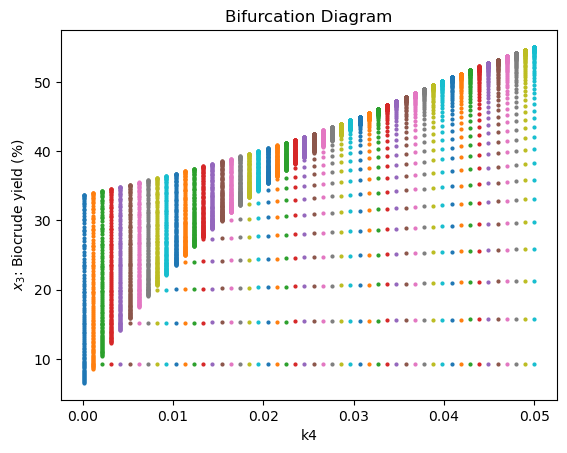

In [24]:
k4_test = np.linspace(0.0001, 0.05, 50)
x3_values = np.linspace(0, 60, 100)

for k4_val in k4_test:
    x3_final_values = []
    for x3_val in x3_values:
        y = odeint(MyODEs_2, initial_y, [0, x3_val], args=(k4_val,))
        x3_final_values.append(y[-1, 4]) 
    plt.plot(k4_val * np.ones_like(x3_values), x3_final_values, 'o', markersize=2, label=f'k4 = {k4_val}')
plt.xlabel("k4")
plt.ylabel('$x_3$: Biocrude yield (%)')
plt.title("Bifurcation Diagram")
#plt.legend(loc='best')
plt.show()

# LOCAL SENSITIVITY ANALYSIS



In [13]:
# nominal parameter values (from the optimization above)
k1_p_nominal = k1_p
k2_p_nominal = k2_p
k1_1_nominal = k1_1
k2_1_nominal = k2_1
k1_c_nominal = k1_c
k2_c_nominal = k2_c
k4_nominal = k4
k5_nominal = k5
k3_nominal = k3
k6_nominal = k6

t = np.linspace(0, 100, 100)
y0 = np.array([protein[0], lipids[0], carbs[0], aqueous[0], biocrude[0], gas[0]])
nominal_solution = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))

In [14]:
perturbation_size = 0.01 #small change
parameters = [k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal]
perturbed_solutionk1_p = odeint(MyODEs, y0, t, args=(k1_p_nominal*perturbation_size, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk2_p = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal*perturbation_size, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk1_1 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal*perturbation_size, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk2_1 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal*perturbation_size, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk1_c = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal*perturbation_size, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk2_c = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal*perturbation_size, k4_nominal, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk4 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal*perturbation_size, k5_nominal, k3_nominal, k6_nominal))
perturbed_solutionk5 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal*perturbation_size, k3_nominal, k6_nominal))
perturbed_solutionk3 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal*perturbation_size, k6_nominal))
perturbed_solutionk6 = odeint(MyODEs, y0, t, args=(k1_p_nominal, k2_p_nominal, k1_1_nominal, k2_1_nominal, k1_c_nominal, k2_c_nominal, k4_nominal, k5_nominal, k3_nominal, k6_nominal*perturbation_size))

In [15]:
x3_nominal = nominal_solution[:, 4]  

x3_perturbedk1_p=perturbed_solutionk1_p[:, 4]
x3_perturbedk2_p= perturbed_solutionk2_p[:, 4]
x3_perturbedk1_1= perturbed_solutionk1_1[:, 4]
x3_perturbedk2_1= perturbed_solutionk2_1[:, 4]
x3_perturbedk1_c= perturbed_solutionk1_c[:, 4]
x3_perturbedk2_c=perturbed_solutionk2_c[:, 4]
x3_perturbedk4=perturbed_solutionk4[:, 4]
x3_perturbedk5=perturbed_solutionk5[:, 4]
x3_perturbedk3=perturbed_solutionk3[:, 4]
x3_perturbedk6=perturbed_solutionk6[:, 4]

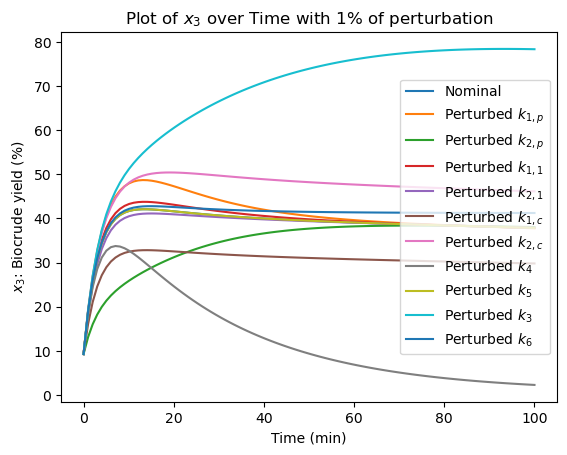

In [16]:
plt.plot(t, x3_nominal, label='Nominal')
plt.plot(t, x3_perturbedk1_p, label='Perturbed $k_{1,p}$')
plt.plot(t, x3_perturbedk2_p, label='Perturbed $k_{2,p}$')
plt.plot(t, x3_perturbedk1_1, label='Perturbed $k_{1,1}%$')
plt.plot(t, x3_perturbedk2_1, label='Perturbed $k_{2,1}$')
plt.plot(t, x3_perturbedk1_c, label='Perturbed $k_{1,c}$')
plt.plot(t, x3_perturbedk2_c, label='Perturbed $k_{2,c}$')
plt.plot(t, x3_perturbedk4, label='Perturbed $k_4$')
plt.plot(t, x3_perturbedk5, label='Perturbed $k_5$')
plt.plot(t, x3_perturbedk3, label='Perturbed $k_3$')
plt.plot(t, x3_perturbedk6, label='Perturbed $k_6$')

# Adding labels and title
plt.xlabel('Time (min)')
plt.ylabel('$x_3$: Biocrude yield (%)')
plt.title('Plot of $x_3$ over Time with 1% of perturbation')
plt.savefig('smallchange.png')
plt.legend();

In [17]:
print(x3_nominal[-1])


37.85343505680874


In [18]:
#Sensitivity to k1_p
fractional_change_x3_k1_p = (x3_perturbedk1_p - x3_nominal) / x3_nominal
sensitivity_x3k1p = fractional_change_x3_k1_p / perturbation_size

#same k2_p
fractional_change_x3_k2_p = (x3_perturbedk2_p - x3_nominal) / x3_nominal
sensitivity_x3k2p = fractional_change_x3_k2_p / perturbation_size

#k1_1
fractional_change_x3_k1_1 = (x3_perturbedk1_1 - x3_nominal) / x3_nominal
sensitivity_x3k11 = fractional_change_x3_k1_1 / perturbation_size

#k2_l
fractional_change_x3_k2_1 = (x3_perturbedk2_1 - x3_nominal) / x3_nominal
sensitivity_x3k21 = fractional_change_x3_k2_1 / perturbation_size

#k1_c
fractional_change_x3_k1_c = (x3_perturbedk1_c - x3_nominal) / x3_nominal
sensitivity_x3k1c = fractional_change_x3_k1_c / perturbation_size

#k2_c
fractional_change_x3_k2_c = (x3_perturbedk2_c - x3_nominal) / x3_nominal
sensitivity_x3k2c = fractional_change_x3_k2_c / perturbation_size

#k4
fractional_change_x3_k4 = (x3_perturbedk4 - x3_nominal) / x3_nominal
sensitivity_x3k4 = fractional_change_x3_k4 / perturbation_size

#k3
fractional_change_x3_k5 = (x3_perturbedk5 - x3_nominal) / x3_nominal
sensitivity_x3k5 = fractional_change_x3_k5 / perturbation_size

#k5
fractional_change_x3_k3 = (x3_perturbedk3 - x3_nominal) / x3_nominal
sensitivity_x3k3 = fractional_change_x3_k3 / perturbation_size

#k6
fractional_change_x3_k6 = (x3_perturbedk6 - x3_nominal) / x3_nominal
sensitivity_x3k6 = fractional_change_x3_k6 / perturbation_size


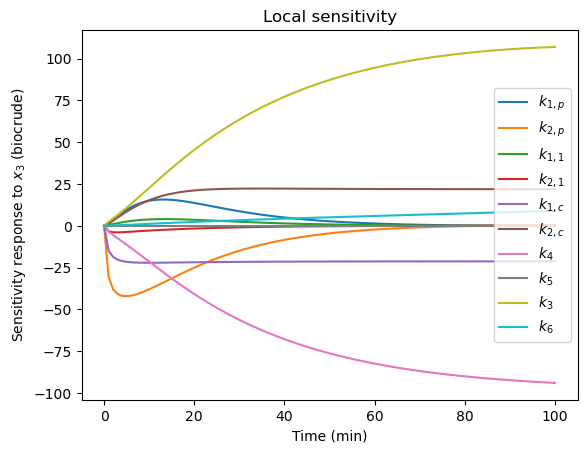

In [19]:
sensitivity_vars = [sensitivity_x3k1p, sensitivity_x3k2p, sensitivity_x3k11, sensitivity_x3k21, sensitivity_x3k1c, sensitivity_x3k2c, sensitivity_x3k4, sensitivity_x3k5, sensitivity_x3k3, sensitivity_x3k6]
labels = ['$k_{1,p}$', '$k_{2,p}$', '$k_{1,1}$', '$k_{2,1}$', '$k_{1,c}$', '$k_{2,c}$', '$k_{4}$', '$k_5$', '$k_3$', '$k_6$']
for i, sensitivity_var in enumerate(sensitivity_vars):
    plt.plot(t, sensitivity_var, label=labels[i])

plt.xlabel('Time (min)')
plt.ylabel('Sensitivity response to $x_3$ (biocrude)')
plt.title('Local sensitivity')
plt.legend()
plt.savefig('local_sensitivity.png')
plt.show()

# GLOBAL SENSITIVITY ANALYSIS

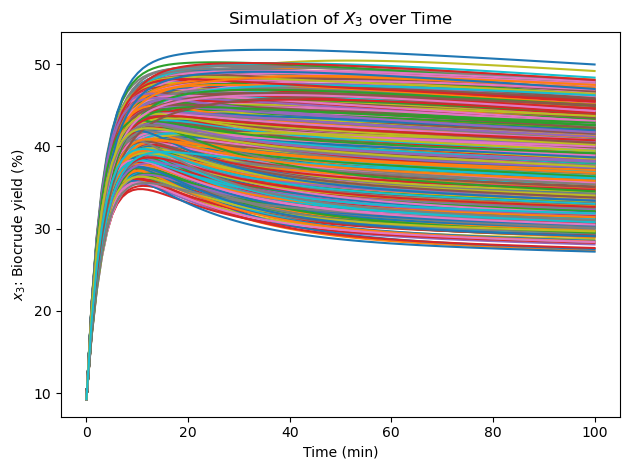

In [20]:
N = 1000;
k1_p_rand = np.random.uniform(0.75 * k1_p_nominal, 1.25 * k1_p_nominal, N)
k2_p_rand = np.random.uniform(0.75 * k2_p_nominal, 1.25 * k2_p_nominal, N)
k1_1_rand = np.random.uniform(0.75 * k1_1_nominal, 1.25 * k1_1_nominal, N)
k2_1_rand = np.random.uniform(0.75 * k2_1_nominal, 1.25 * k2_1_nominal, N)
k1_c_rand = np.random.uniform(0.75 * k1_c_nominal, 1.25 * k1_c_nominal, N)
k2_c_rand = np.random.uniform(0.75 * k2_c_nominal, 1.25 * k2_c_nominal, N)
k4_rand = np.random.uniform(0.75 * k4_nominal, 1.25 * k4_nominal, N)
k5_rand = np.random.uniform(0.75 * k5_nominal, 1.25 * k5_nominal, N)
k3_rand = np.random.uniform(0.75 * k3_nominal, 1.25 * k3_nominal, N)
k6_rand = np.random.uniform(0.75 * k6_nominal, 1.25 * k6_nominal, N)

x3 = np.zeros(N)

for m in np.arange(0,N,1):
    output = odeint(MyODEs, y0, t, args = (k1_p_rand[m],k2_p_rand[m],k1_1_rand[m],k2_1_rand[m],k1_c_rand[m],k2_c_rand[m],k4_rand[m],k5_rand[m],k3_rand[m],k6_rand[m]));
    #print(output)
    plt.plot(t,output[:,4]);
    plt.xlabel("time");
    plt.ylabel("X3");
    x3[m]=output[-1,4];

plt.xlabel("Time (min)") 
plt.ylabel('$x_3$: Biocrude yield (%)')
plt.title("Simulation of $X_3$ over Time") 
plt.tight_layout()  
plt.savefig('globalsensitivity1.png')
plt.show()

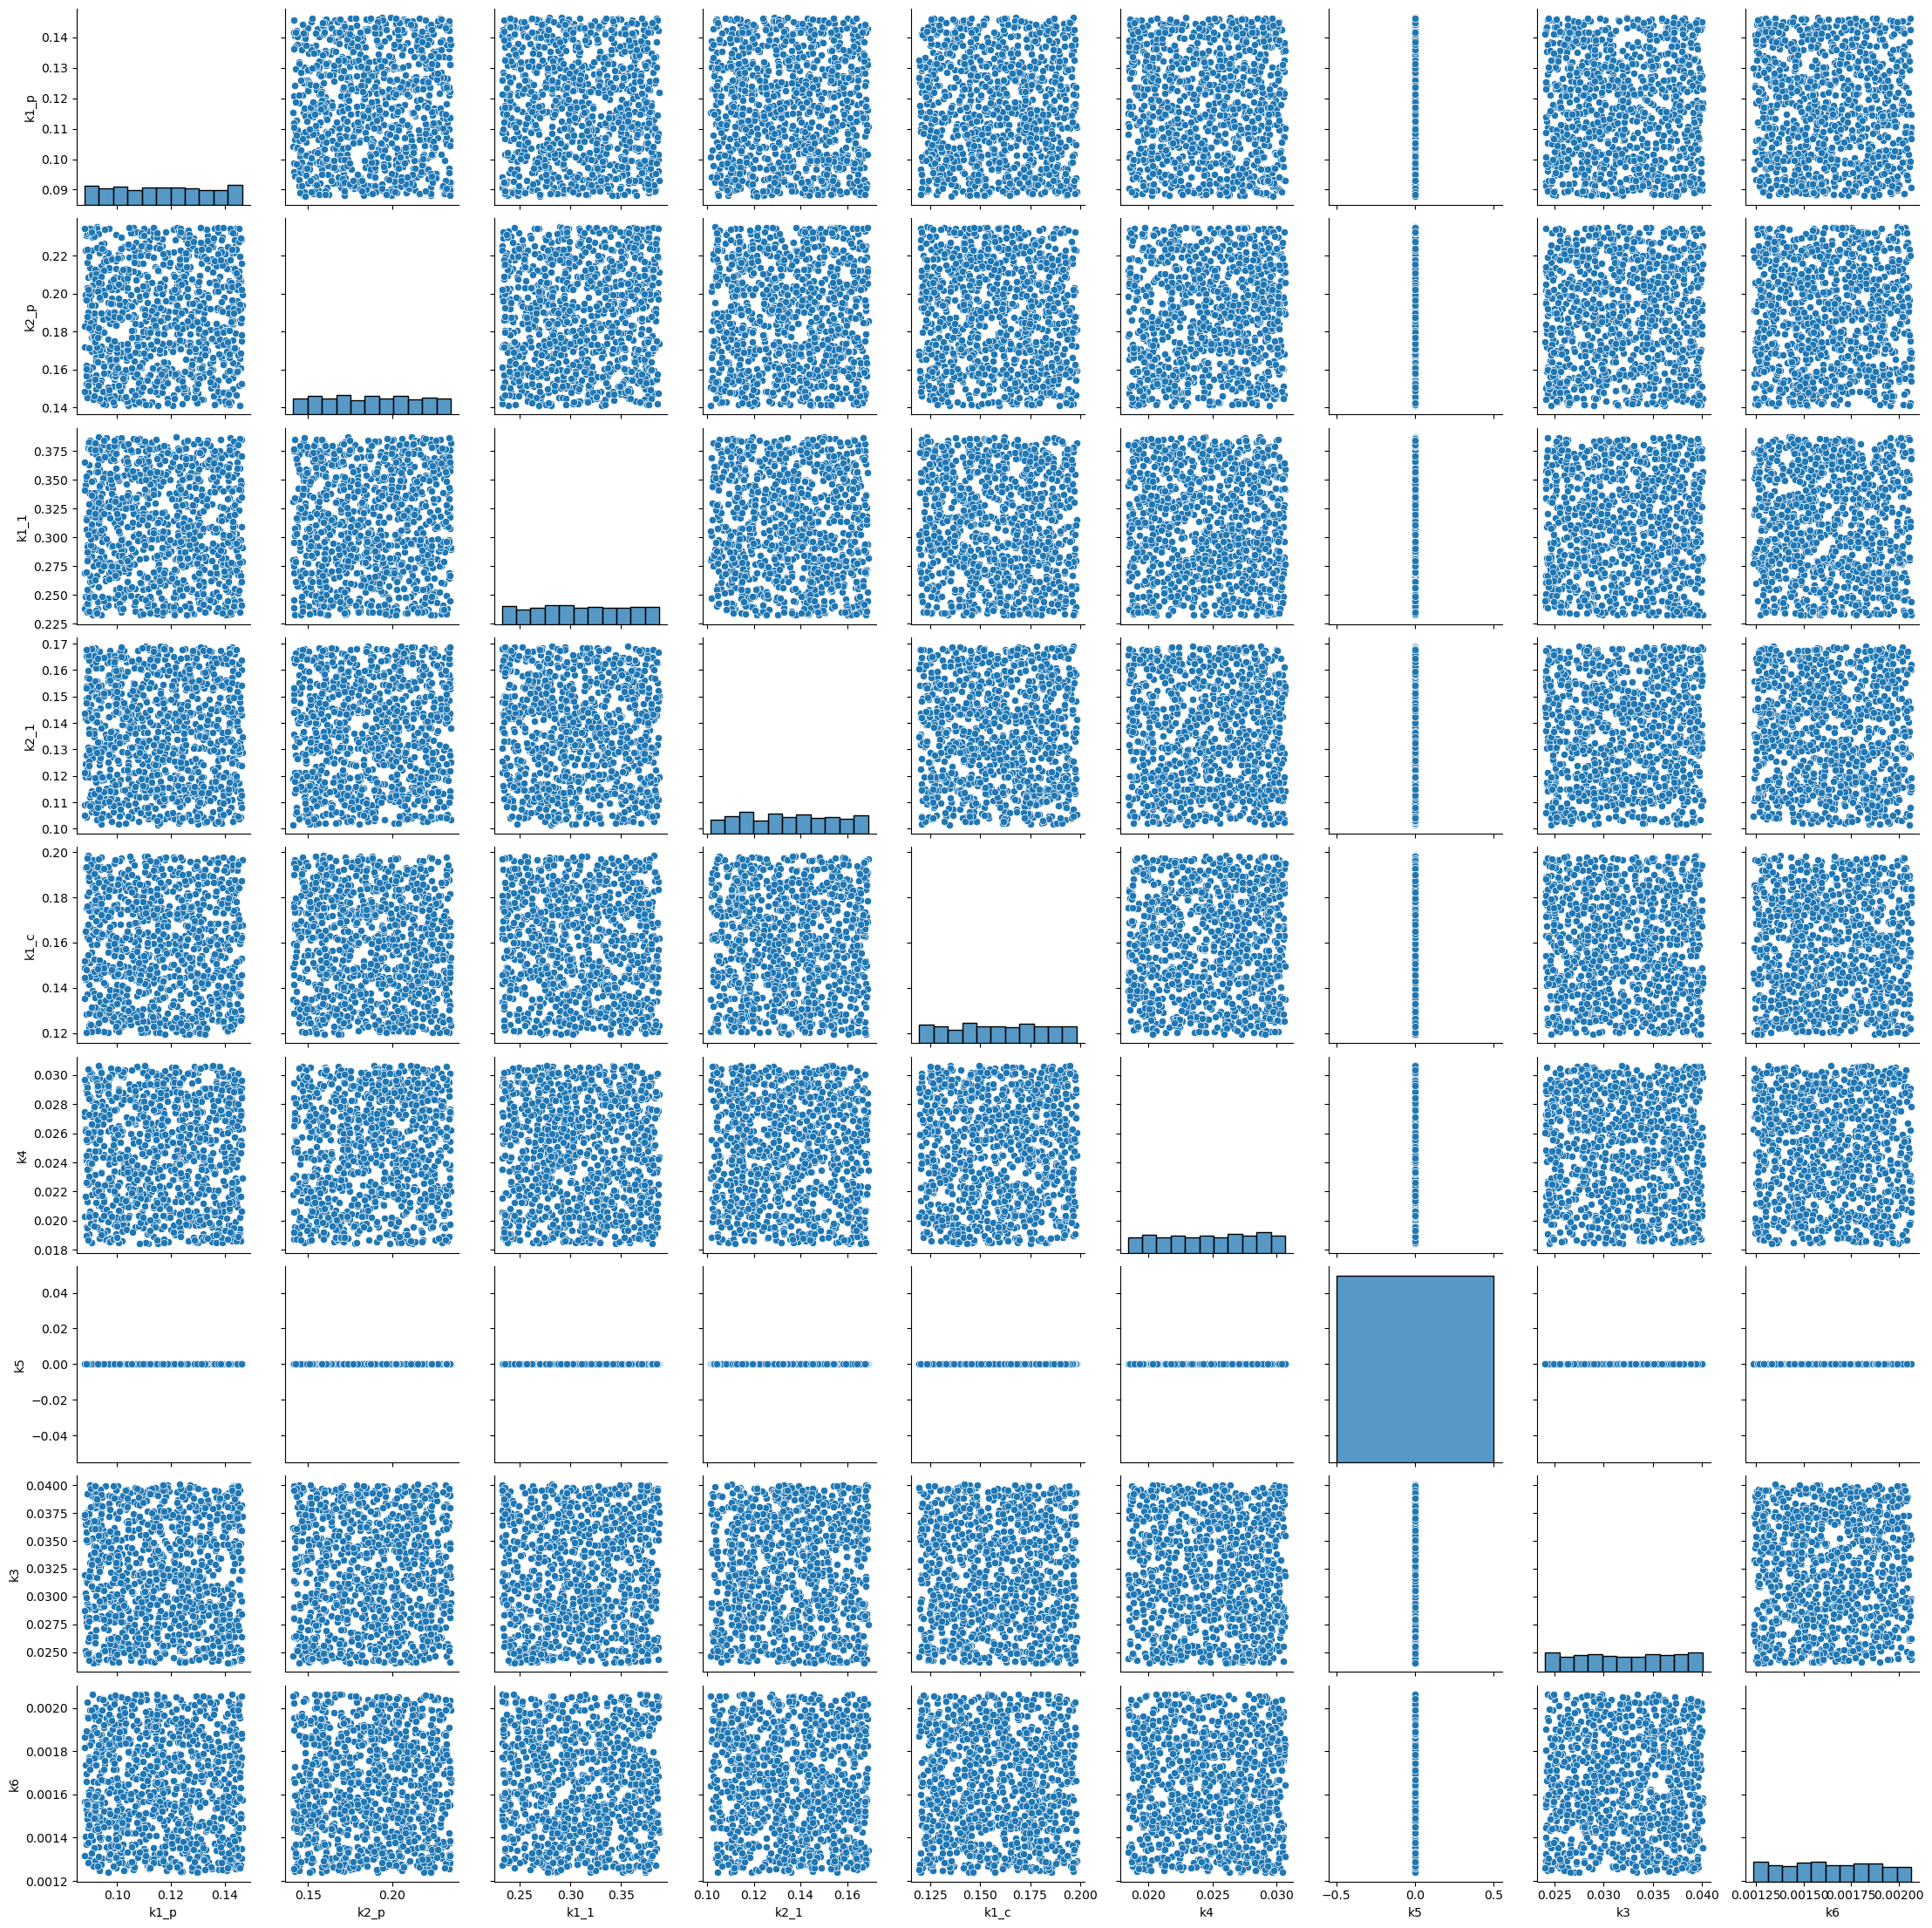

In [21]:
tmp = {'k1_p':k1_p_rand, 'k2_p':k2_p_rand, 'k1_1':k1_1_rand, 'k2_1':k2_1_rand, 'k1_c':k1_c_rand, 'k4':k4_rand, 'k5':k5_rand, 'k3':k3_rand, 'k6':k6_rand};
df = pd.DataFrame(tmp);
del(tmp)

sns.pairplot(df)
plt.show()

In [22]:
# Normalize y and X
y = (37.85343505680874-x3)/37.85343505680874; 
X = np.c_[(k1_p_nominal - k1_p_rand) / k1_p_nominal,(k2_p_nominal - k2_p_rand) / k2_p_nominal,(k1_1_nominal - k1_1_rand) / k1_1_nominal,(k2_1_nominal - k2_1_rand) / k2_1_nominal,(k1_c_nominal - k1_c_rand) / k1_c_nominal,(k2_c_nominal - k2_c_rand) / k2_c_nominal,(k4_nominal - k4_rand) / k4_nominal,(k5_nominal - k5_rand) / 0.000001,(k3_nominal - k3_rand) / k3_nominal,(k6_nominal - k6_rand) / k6_nominal]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          2.172e+04
Date:                Sun, 04 Feb 2024   Prob (F-statistic):                        0.00
Time:                        19:52:19   Log-Likelihood:                          3360.0
No. Observations:                1000   AIC:                                     -6702.
Df Residuals:                     991   BIC:                                     -6658.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

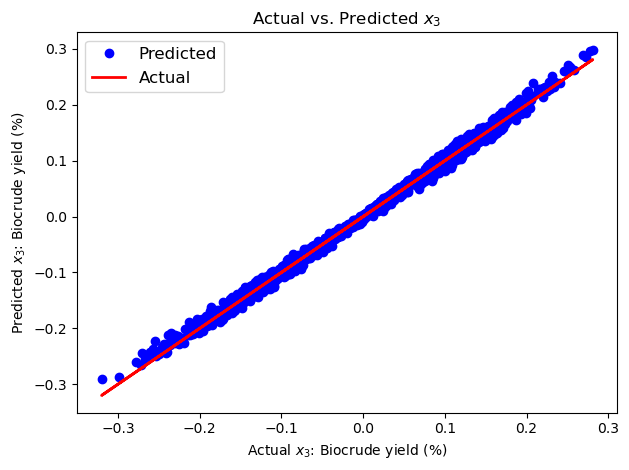

In [23]:
model = sm.OLS(y, X).fit()
print(model.summary())
coefficients = model.params

k1_pf = coefficients[0]
k2_pf = coefficients[1]
k1_1f = coefficients[2]
k2_1f = coefficients[3]
k1_cf = coefficients[4]
k2_cf = coefficients[5]
k4f = coefficients[6]
k5f = coefficients[7]
k3f = coefficients[8]
k6f = coefficients[9]

plt.plot(y, model.predict(X), "o", color="blue", label="Predicted")  
plt.plot(y, y, "-", color="red", label="Actual", linewidth=2)  

plt.ylabel("Predicted $x_3$: Biocrude yield (%)")  
plt.xlabel("Actual $x_3$: Biocrude yield (%)") 
plt.title("Actual vs. Predicted $x_3$ ") 
plt.legend(fontsize=12)  
plt.tight_layout() 
plt.savefig('globalsensitivity2.png')
plt.show()